In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import regex as re
from sklearn.svm import SVC
from wordcloud import WordCloud, ImageColorGenerator

Ссылка на датасет https://www.kaggle.com/datasets/datatattle/email-classification-nlp/data.
Поставлена задача бинарной классификации - определить является СМС спам или нет.

In [4]:
train = pd.read_csv(r"./SMS_train.csv", encoding='cp1252')
test = pd.read_csv(r"./SMS_test.csv",encoding='cp1252')

train.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        957 non-null    int64 
 1   Message_body  957 non-null    object
 2   Label         957 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        125 non-null    int64 
 1   Message_body  125 non-null    object
 2   Label         125 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Проверим сбалансированность классов.

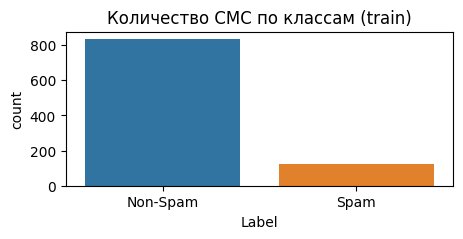

In [7]:
plt.figure(figsize=(5,2))
sns.countplot(data=train, x='Label')
plt.title('Количество СМС по классам (train)')
plt.show()

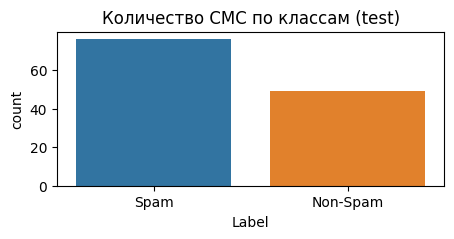

In [8]:
plt.figure(figsize=(5,2))
sns.countplot(data=test, x='Label')
plt.title('Количество СМС по классам (test)')
plt.show()

Видим, что классы в тренировочном датасете несбалансированы. Будем учитывать это, при построении моделей.

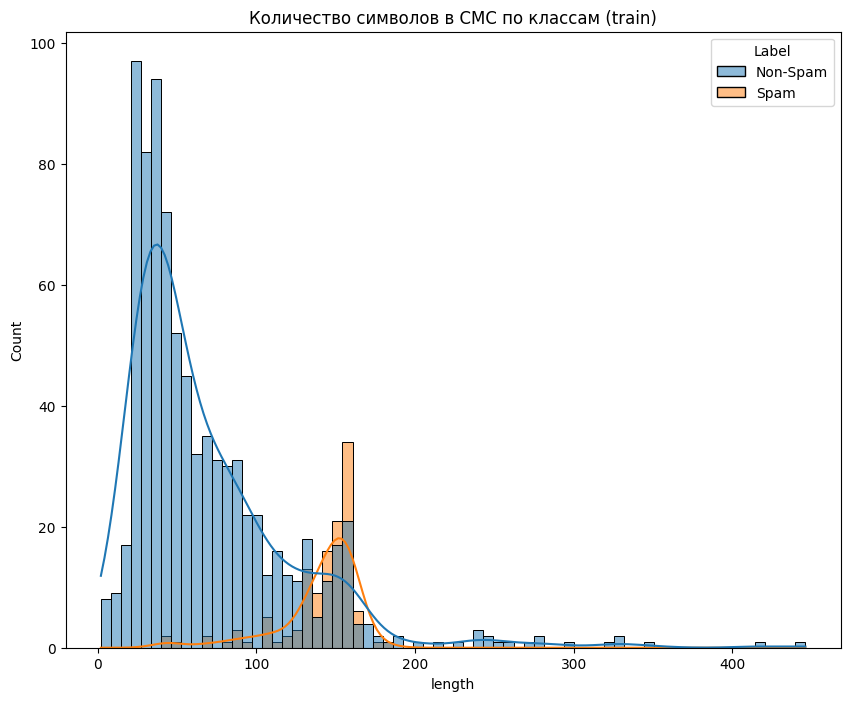

In [9]:
train['length'] = train.Message_body.apply(len)

plt.figure(figsize=(10,8))
sns.histplot(data=train,x='length',hue='Label',kde= True,bins=70)
plt.title('Количество символов в СМС по классам (train)')
plt.show()

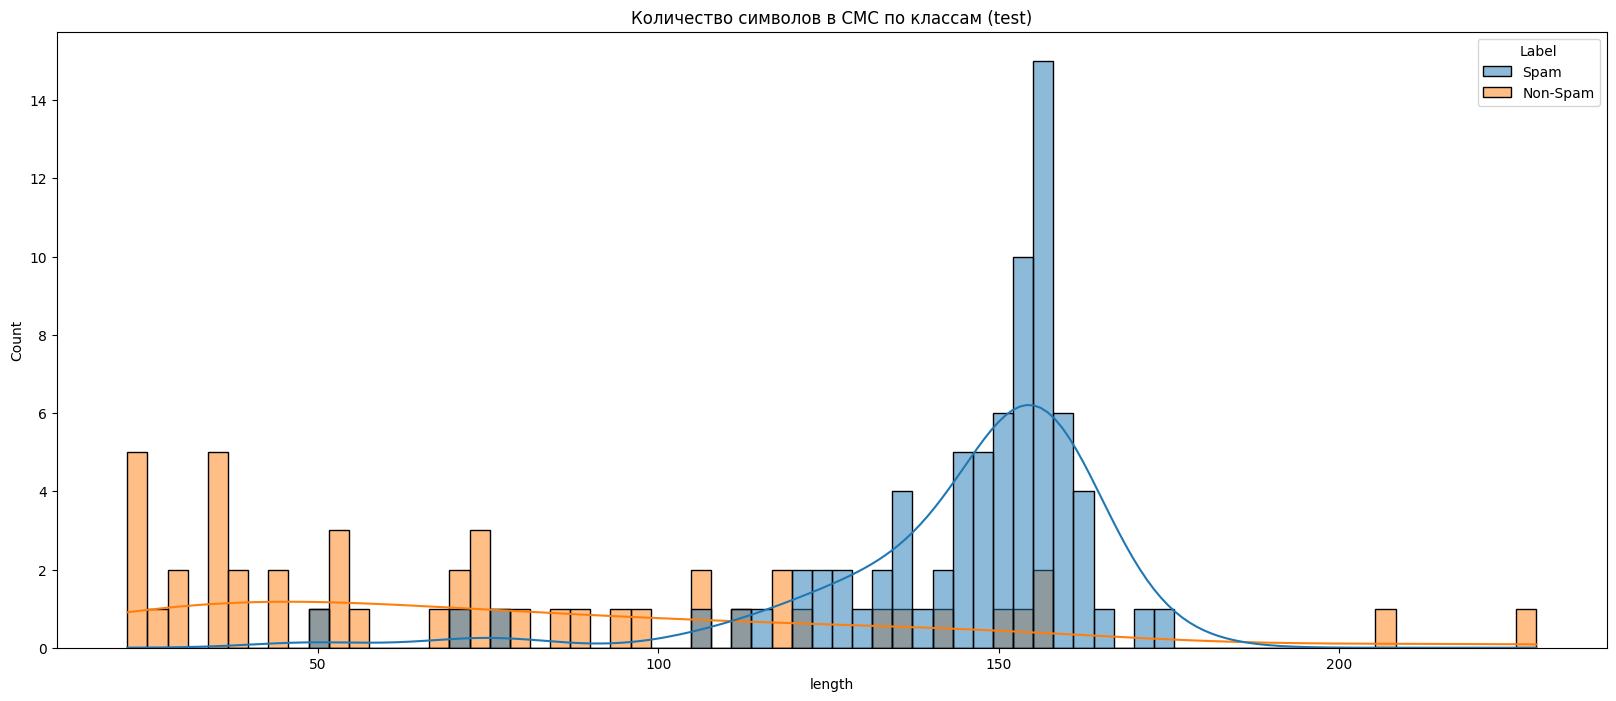

In [10]:
test['length'] = test.Message_body.apply(len)

plt.figure(figsize=(20,8))
sns.histplot(data=test,x='length',hue='Label',kde= True,bins=70)
plt.title('Количество символов в СМС по классам (test)')
plt.show()

Видим, схожую ситуацию по количеству символов в СМС в тренировочном и тестовом датасетах - видно нормальное распределение числа символов, и в спам письмах чаще число символов в СМС больше, чем в не спам письмах.

In [11]:
del train['length']
del test['length']

Выведем самые часто повторяющиеся слова в письмах по классам.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


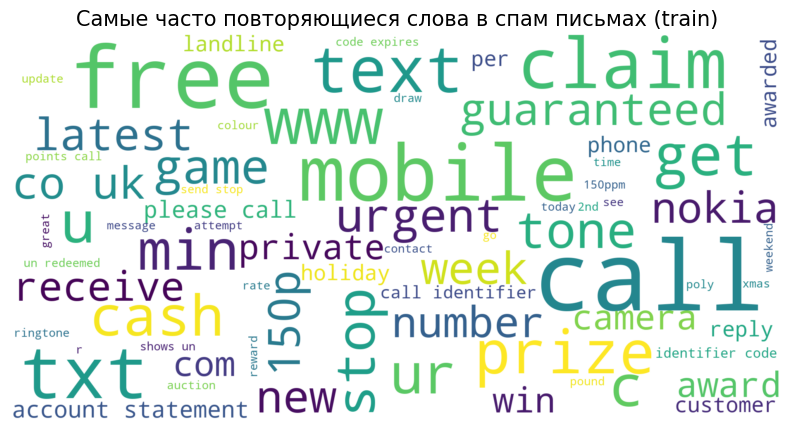

In [12]:
import re
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

message_body_spam = ",".join(spam_mail.lower() for spam_mail in train.Message_body[train.Label == 'Spam'])

wordcloud = WordCloud(max_font_size=50,
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Самые часто повторяющиеся слова в спам письмах (train)',fontsize=15)
plt.show()

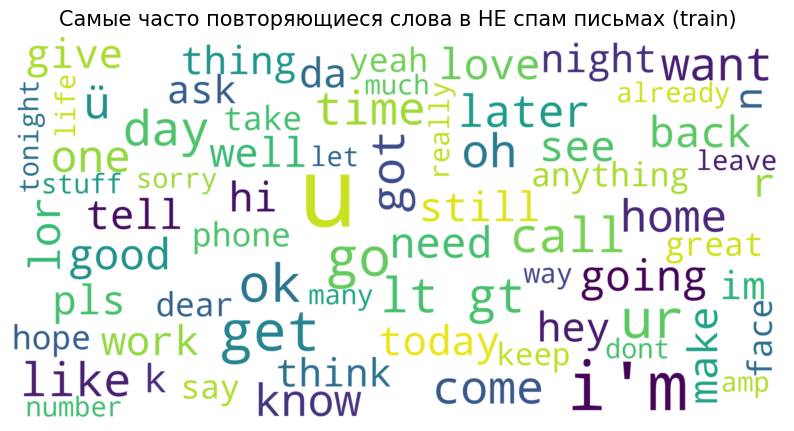

In [13]:
message_body_spam = ",".join(spam_mail.lower() for spam_mail in train.Message_body[train.Label == 'Non-Spam'])

wordcloud = WordCloud(max_font_size=50,
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Самые часто повторяющиеся слова в НЕ спам письмах (train)',fontsize=15)
plt.show()

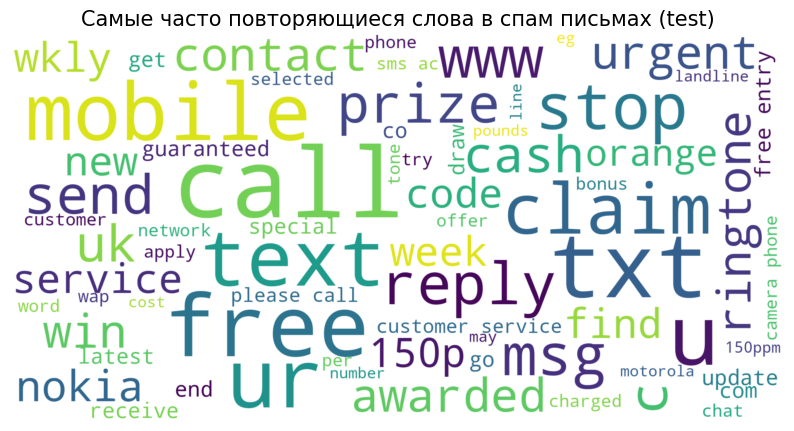

In [14]:
message_body_spam = ",".join(spam_mail.lower() for spam_mail in test.Message_body[test.Label == 'Spam'])

wordcloud = WordCloud(max_font_size=50,
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Самые часто повторяющиеся слова в спам письмах (test)',fontsize=15)
plt.show()

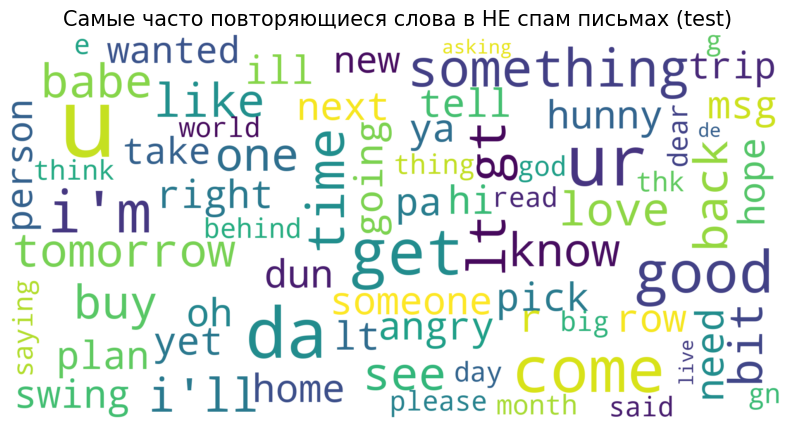

In [15]:
message_body_spam = ",".join(spam_mail.lower() for spam_mail in test.Message_body[test.Label == 'Non-Spam'])

wordcloud = WordCloud(max_font_size=50,
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Самые часто повторяющиеся слова в НЕ спам письмах (test)',fontsize=15)
plt.show()

Ситуация соответствует логике - в обоих датасетах в случаях спам писем преобладают слова "free", "award", "call", "prize", говорящие о том, что клиенту навязывают ненужные услуги/акции. В случае Не спам писем видны слова, чаще встречающиеся в живом общении "U", "like", "hunny", "good", "ur", "im".

Теперь проведем с датасетами операции:

- удаления stop words
- приведения все к нижнему регистру
- лемматизации
- удаления знаков препинания

In [16]:
import nltk
nltk.download('wordnet')

def clean_text(sentence: str):
    result = sentence.lower()
    result = result.replace('\\', ' ')
    result = re.sub(r"&gt|&lt|p&gt|(@\[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", result)
    result = " ".join([word for word in result.split() if word not in stop_words])
    return result

def tokenize(x):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(x)

def lemmatize(x):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
train_clear = train.copy()
train_clear['Message_body'] = train_clear['Message_body'].apply(lambda sentence: clean_text(sentence))

train_clear['tokens'] = train_clear['Message_body'].map(tokenize)
train_clear['lemmas'] = train_clear['tokens'].map(lemmatize)

In [18]:
test_clear = test.copy()
test_clear['Message_body'] = test_clear['Message_body'].apply(lambda sentence: clean_text(sentence))

test_clear['tokens'] = test_clear['Message_body'].map(tokenize)
test_clear['lemmas'] = test_clear['tokens'].map(lemmatize)

Для обучения моделей разделим тренировочный датасет на train и test

In [19]:
data_labels = train_clear['Label']
data_tweets = train_clear['lemmas']

data_labels = data_labels.replace(['Spam'], 1)
data_labels = data_labels.replace(['Non-Spam'], 0)

train_X, test_X, train_y, test_y = train_test_split(data_tweets,
                                                    data_labels,
                                                    test_size=0.25,
                                                    random_state = 42)

val_y = test_clear['Label']
val_X = test_clear['lemmas']

val_y = val_y.replace(['Spam'], 1)
val_y = val_y.replace(['Non-Spam'], 0)

Попробуем CountVectorizer и XGBClassifier.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

cv = CountVectorizer()
model = XGBClassifier(max_depth = 12, grow_policy='lossguide', max_leaves=200)

model_cv_1 = Pipeline([('vectorizer', cv), ('classifier', model)])

model_cv_1.fit(train_X, train_y)

f1_score(val_y, model_cv_1.predict(val_X))

0.8217054263565892

<Axes: >

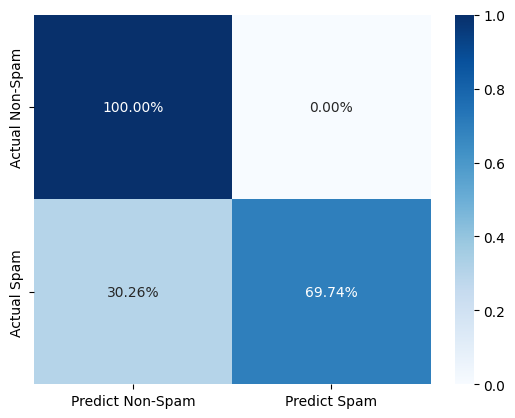

In [21]:
from sklearn.metrics import confusion_matrix

conf_matrix = pd.DataFrame(confusion_matrix(val_y, model_cv_1.predict(val_X)))
conf_matrix.columns = ['Predict Non-Spam', 'Predict Spam']
conf_matrix.index = ['Actual Non-Spam', 'Actual Spam']
conf_matrix.iloc[0] = conf_matrix.iloc[0]/conf_matrix.sum(axis=1)[0]
conf_matrix.iloc[1] = conf_matrix.iloc[1]/conf_matrix.sum(axis=1)[1]

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2%')

Теперь попробуем TfidfVectorizer и LogisticRegression с подбором гиперпараметров при помощи GridSearchCV.

In [22]:
model_lr_1 = Pipeline(steps = [('tf', TfidfVectorizer()), ('lgrg', LogisticRegression())])

pgrid_lr = {
 'tf__max_features' : [1000, 2000, 3000, 4000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced'],
 'lgrg__C' : [1.0, 0.9]
}

model_lr_cv_1 = GridSearchCV(model_lr_1, pgrid_lr, cv=7, n_jobs=-1, verbose=2)

model_lr_cv_1.fit(train_X, train_y)

Fitting 7 folds for each of 128 candidates, totalling 896 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
448 fits failed out of a total of 896.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
224 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lgrg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lgrg__C': [1.0, 0.9],
                         'lgrg__class_weight': ['balanced'],
                         'lgrg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'tf__max_features': [1000, 2000, 3000, 4000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__use_idf': [True, False]},
             verbose=2)

In [23]:
model_lr_cv_1.best_params_

{'lgrg__C': 1.0,
 'lgrg__class_weight': 'balanced',
 'lgrg__penalty': 'none',
 'tf__max_features': 2000,
 'tf__ngram_range': (1, 1),
 'tf__use_idf': False}

In [26]:
print('Train score', model_lr_cv_1.score(test_X, test_y))
print('Test score', model_lr_cv_1.score(val_X, val_y))
print('Test F1 Score', f1_score(val_y, model_lr_cv_1.predict(val_X)))

Train score 0.9708333333333333
Test score 0.904
Test F1 Score 0.9142857142857143


<Axes: >

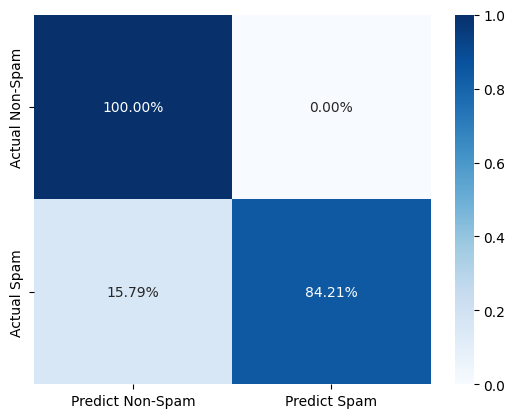

In [27]:
conf_matrix = pd.DataFrame(confusion_matrix(val_y, model_lr_cv_1.predict(val_X)))
conf_matrix.columns = ['Predict Non-Spam', 'Predict Spam']
conf_matrix.index = ['Actual Non-Spam', 'Actual Spam']
conf_matrix.iloc[0] = conf_matrix.iloc[0]/conf_matrix.sum(axis=1)[0]
conf_matrix.iloc[1] = conf_matrix.iloc[1]/conf_matrix.sum(axis=1)[1]

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2%')

Видим, что обе модели не ошибаются в детекции НЕ спама, что играет важную роль в данной задаче, и F1-score логиcтической регрессии с подбором гиперпараметров выше XGBClassifier
.

Попробуем Word2VecVectorizer и XGBClassifier.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
import gensim
from gensim.models import Word2Vec

class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, epochs=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.vector_size = vector_size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.epochs = epochs
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            vector_size=self.vector_size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, epochs=self.epochs, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.key_to_index]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.vector_size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.vector_size)

In [29]:
model = XGBClassifier(max_depth = 12, grow_policy='lossguide', max_leaves=200)

w2v_vectorizer = GensimWord2VecVectorizer(vector_size=50, min_count=10, sg=1, alpha=0.025, epochs=50)

model_xgb_2 = Pipeline([('vectorizer', w2v_vectorizer), ('classifier', model)])

model_xgb_2.fit(train_X, train_y)

print(f1_score(val_y, model_xgb_2.predict(val_X)))

0.649122807017544


<Axes: >

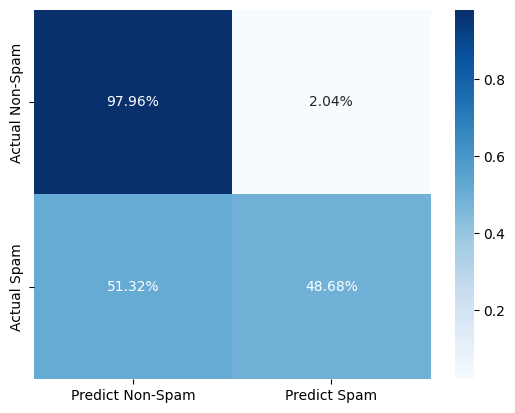

In [30]:
conf_matrix = pd.DataFrame(confusion_matrix(val_y, model_xgb_2.predict(val_X)))
conf_matrix.columns = ['Predict Non-Spam', 'Predict Spam']
conf_matrix.index = ['Actual Non-Spam', 'Actual Spam']
conf_matrix.iloc[0] = conf_matrix.iloc[0]/conf_matrix.sum(axis=1)[0]
conf_matrix.iloc[1] = conf_matrix.iloc[1]/conf_matrix.sum(axis=1)[1]

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2%')

Видим хуже значения F1-Score. Посмотрим на результаты Word2VecVectorizer и LogisticRegression с подбором гиперпараметров при помощи GridSearchCV.

In [31]:
model_lr_2 = Pipeline(steps = [('vectorizer', w2v_vectorizer), ('lgrg', LogisticRegression())])

pgrid_lgrg = {
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced'],
 'lgrg__C' : [1.0, 0.9]
}

model_lr_cv_2 = GridSearchCV(model_lr_2, pgrid_lgrg, cv=5, n_jobs=-1, verbose=2)

model_lr_cv_2.fit(train_X, train_y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        GensimWord2VecVectorizer(epochs=50,
                                                                 min_count=10,
                                                                 sg=1,
                                                                 vector_size=50)),
                                       ('lgrg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lgrg__C': [1.0, 0.9],
                         'lgrg__class_weight': ['balanced'],
                         'lgrg__penalty': ['l1', 'l2', 'elasticnet', 'none']},
             verbose=2)

In [32]:
model_lr_cv_2.best_params_

{'lgrg__C': 1.0, 'lgrg__class_weight': 'balanced', 'lgrg__penalty': 'none'}

In [33]:
print('Train score', model_lr_cv_2.score(test_X, test_y))
print('Test score', model_lr_cv_2.score(val_X, val_y))
print('Test F1 score', f1_score(val_y, model_lr_cv_2.predict(val_X)))

Train score 0.7833333333333333
Test score 0.8
Test F1 score 0.8366013071895425


<Axes: >

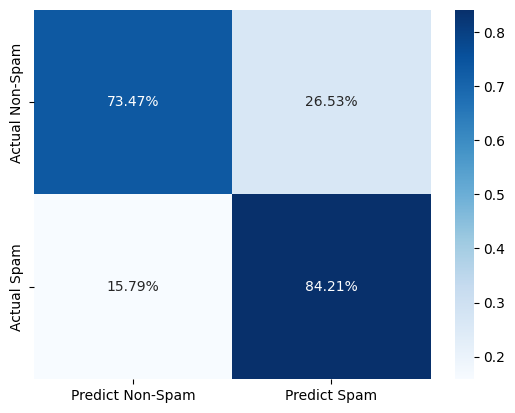

In [34]:
conf_matrix = pd.DataFrame(confusion_matrix(val_y, model_lr_cv_2.predict(val_X)))
conf_matrix.columns = ['Predict Non-Spam', 'Predict Spam']
conf_matrix.index = ['Actual Non-Spam', 'Actual Spam']
conf_matrix.iloc[0] = conf_matrix.iloc[0]/conf_matrix.sum(axis=1)[0]
conf_matrix.iloc[1] = conf_matrix.iloc[1]/conf_matrix.sum(axis=1)[1]

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2%')

Использование логистической регрессии с подбором гиперпараметров повысило F1-score до значения 0.83 на валидационном датасете, но оно уступает предыдущему значению TfidfVectorizer с LogisticRegression и с подбором гиперпараметров при помощи GridSearchCV - 0.91.

Далее будем использовать рекуррентную нейронную сеть LSTM.

In [35]:
import tensorflow as tf
from keras import layers
import tensorflow.keras.layers
import tensorflow.keras as keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [36]:
train_list = []
for text in train_X:
    train_list.append(text)

test_list = []
for text in test_X:
    test_list.append(text)

In [37]:
vocab_max_size = len(set(train_list))
max_sentence = np.max([len(i) for i in train_list])

In [38]:
vocabulary_len = 5000
one_hot_train = [one_hot(words, vocabulary_len)for words in train_list]
one_hot_test = [one_hot(words, vocabulary_len)for words in test_list]

In [39]:
max_sentence_len = 30
pad_train = pad_sequences(one_hot_train, padding = 'pre', maxlen = max_sentence_len)
pad_test = pad_sequences(one_hot_test, padding = 'pre', maxlen = max_sentence_len)

In [40]:
print(pad_train.shape)
print(pad_test.shape)

(717, 30)
(240, 30)


In [41]:
embedding_vector_features = 100
model_lstm = Sequential()

model_lstm.add(Embedding(vocabulary_len, embedding_vector_features, input_length = max_sentence_len))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(200))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation = 'sigmoid'))
model_lstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics = tf.keras.metrics.BinaryAccuracy())


In [42]:
train_x_ = np.array(pad_train)
test_x_ = np.array(pad_test)

train_y_ = np.array(train_y)
test_y_ = np.array(test_y)

In [43]:
history =  model_lstm.fit(train_x_, train_y_, validation_data = (test_x_, test_y_), epochs =100, batch_size = 64)

Epoch 1/100
12/12 [==============================] - 5s 196ms/step - loss: 0.5082 - binary_accuracy: 0.8285 - val_loss: 0.4183 - val_binary_accuracy: 0.8667
Epoch 2/100
12/12 [==============================] - 2s 167ms/step - loss: 0.3832 - binary_accuracy: 0.8745 - val_loss: 0.3701 - val_binary_accuracy: 0.8667
Epoch 3/100
12/12 [==============================] - 3s 227ms/step - loss: 0.2808 - binary_accuracy: 0.8759 - val_loss: 0.2536 - val_binary_accuracy: 0.9000
Epoch 4/100
12/12 [==============================] - 2s 164ms/step - loss: 0.1640 - binary_accuracy: 0.9456 - val_loss: 0.1566 - val_binary_accuracy: 0.9458
Epoch 5/100
12/12 [==============================] - 2s 135ms/step - loss: 0.0830 - binary_accuracy: 0.9791 - val_loss: 0.1226 - val_binary_accuracy: 0.9583
Epoch 6/100
12/12 [==============================] - 2s 191ms/step - loss: 0.0465 - binary_accuracy: 0.9874 - val_loss: 0.2151 - val_binary_accuracy: 0.9333
Epoch 7/100
12/12 [==============================] - 2s 20

In [44]:
model_loss = pd.DataFrame(model_lstm.history.history)
model_loss

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.508229,0.828452,0.418314,0.866667
1,0.383215,0.874477,0.370057,0.866667
2,0.280828,0.875872,0.253593,0.900000
3,0.163971,0.945607,0.156592,0.945833
4,0.082977,0.979079,0.122569,0.958333
...,...,...,...,...
95,0.000024,1.000000,0.292144,0.958333
96,0.000014,1.000000,0.293962,0.962500
97,0.000017,1.000000,0.296727,0.962500
98,0.000014,1.000000,0.298027,0.962500


In [45]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [48]:
epochs_range = range(100)

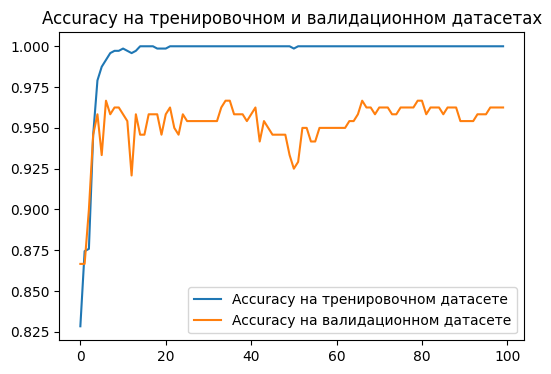

In [49]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, acc, label='Accuracy на тренировочном датасете')
plt.plot(epochs_range, val_acc, label='Accuracy на валидационном датасете')
plt.legend(loc='lower right')
plt.title('Accuracy на тренировочном и валидационном датасетах')
plt.show()

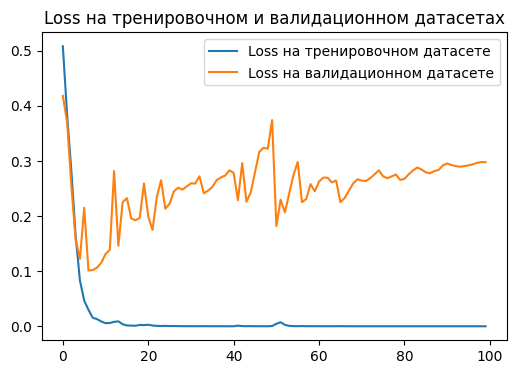

In [50]:
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, loss, label='Loss на тренировочном датасете')
plt.plot(epochs_range, val_loss, label='Loss на валидационном датасете')
plt.legend(loc='upper right')
plt.title('Loss на тренировочном и валидационном датасетах')
plt.show()

Видим, что на валидационном датасете loss функция начинает расти с ростом эпох. Проверим работу нейронной сети на тестовом датасете.

Теперь предскажем класс для тестового датасета при помощи модели нейронной сети.

In [51]:
val_list = []
for text in val_X:
    val_list.append(text)

In [52]:
vocabulary_len = 5000
one_hot_valid = [one_hot(words, vocabulary_len)for words in val_list]
max_sentence_len = 30

pad_val = pad_sequences(one_hot_valid, padding = 'pre', maxlen = max_sentence_len)

In [53]:
print(len(pad_val))
print(pad_val.shape)

125
(125, 30)


In [54]:
val_x_ = np.array(pad_val)
val_y_ = np.array(val_y)

In [55]:
val_y.value_counts()

1    76
0    49
Name: Label, dtype: int64

0 - не спам, 1 - спам.

In [56]:
lstm_preds = model_lstm.predict(pad_val)

4/4 [==============================] - 1s 39ms/step


In [57]:
test_labels = pd.DataFrame(val_y_)
test_labels = test_labels.rename(columns={0 : 'Label'})
test_labels['Prediction'] = lstm_preds
test_labels

,Label,Prediction
0,1,0.999985
1,1,0.990302
2,1,0.999989
3,1,0.999997
4,1,0.999881
...,...,...
120,0,0.000001
121,0,0.000001
122,0,0.000007
123,0,0.000002


<Axes: xlabel='Prediction', ylabel='Count'>

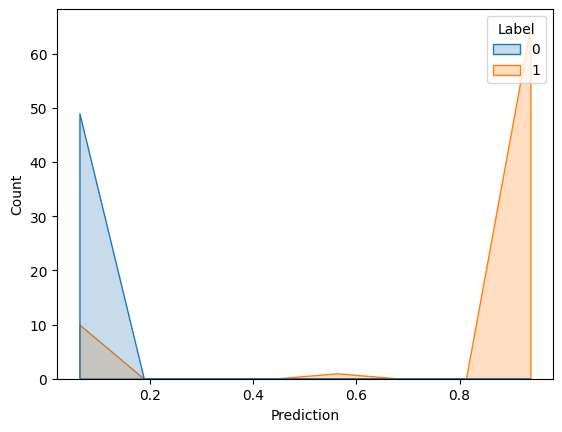

In [59]:
sns.histplot(test_labels, x='Prediction', hue='Label', element='poly')

Модель примерно одинаково распределила количество СМС по классам.

In [61]:
test_labels['Prediction_labels'] = np.round(test_labels['Prediction'])

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(test_labels['Label'], test_labels['Prediction_labels'])

print('Accuracy: {}'.format(accuracy))
print(classification_report(test_labels['Label'], test_labels['Prediction_labels']))

Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        49
           1       1.00      0.87      0.93        76

    accuracy                           0.92       125
   macro avg       0.92      0.93      0.92       125
weighted avg       0.93      0.92      0.92       125



<Axes: >

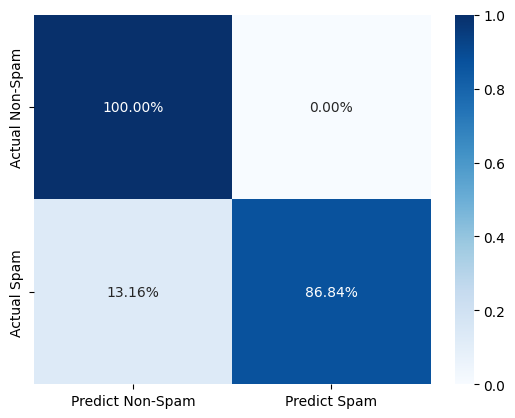

In [63]:
conf_matrix = pd.DataFrame(confusion_matrix(test_labels['Label'], test_labels['Prediction_labels']))
conf_matrix.columns = ['Predict Non-Spam', 'Predict Spam']
conf_matrix.index = ['Actual Non-Spam', 'Actual Spam']
conf_matrix.iloc[0] = conf_matrix.iloc[0]/conf_matrix.sum(axis=1)[0]
conf_matrix.iloc[1] = conf_matrix.iloc[1]/conf_matrix.sum(axis=1)[1]

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2%')

Видим, что аналогично классическим моделям машинного обучения, нейронная сеть не ошиблась в детекции НЕ спама, но снизила процент пропуска спама. Ее F1-score превосходит значения предыдущих моделей.